In [1]:
### the original file was located at: /expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/Fragile_X
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import ttest_ind

In [2]:
dir_fig = 'fragile_x/'

In [3]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff
    
aff_dict_asd = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected_ASD'].tolist()):
    aff_dict_asd[sample] = aff

In [4]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

#this_sample = 'REACH000520'
#this_sample = 'REACH000290'
#this_sample = 'REACH000236_PB'
#print(df_cov[df_cov.SAMPLE == this_sample]['COHORT'].values)
#this_plat = get_plat(this_sample)
#print(this_plat)
#print(df_cov)

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [5]:
#file_in = 'FX_genotypes_famID_trim.txt'
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/Fragile_X/FX_genotypes_famID.txt'
col_names = ["Sample_id", "GB", "Z", "Qual", "Fam_id", "sex", "rel"]
col_names_dict = {i: col_names[i] for i in range(len(col_names))}

df = pd.read_table(file_in, sep='\t', header=None, keep_default_na=False)
df = df.rename(columns=col_names_dict)
df = df.loc[df.Sample_id.str.contains('REACH000')]

# the reference has 60bp or 20 repeats: chrX:147912051-147912110
df['GB_min'] = [min([int(y) for y in x.split('|')]) if x!='.' else '.' for x in df.GB]
df['GB_max'] = [max([int(y) for y in x.split('|')]) if x!='.' else '.' for x in df.GB]
df['repeats_min'] = [20 + int(int(x)/3) if x != '.' else '.' for x in df.GB_min]
df['repeats_max'] = [20 + int(int(x)/3) if x != '.' else '.' for x in df.GB_max]
df['Affected'] = [aff_dict[sample] for sample in df.Sample_id]
df['Platform'] = [plat_dict[sample] for sample in df.Sample_id]
#pd.set_option('display.max_rows', None)
display(df)

file_name = f'{dir_fig}/FMR1_repeat_gts.tsv'
print(file_name)
df.to_csv(file_name, sep='\t', header=True, index=False)

,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
1,REACH000001,29|31,0.20|0.32,0.99,F0001,1,C,29,31,29,30,Yes,ONT
2,REACH000107,0|34,-1.64|0.51,1,F0001,2,P,0,34,20,31,Yes,ONT
3,REACH000226,0|4,-1.64|-1.38,1,F0001,1,P,0,4,20,21,Yes,ONT
4,REACH000026,.,.,.,F0026,1,C,.,.,.,.,Yes,PB
5,REACH000269,.,.,.,F0026,2,P,.,.,.,.,No,PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,REACH000766,.,.,.,F0290,2,C,.,.,.,.,No,PB
269,REACH000767,30|30,0.26|0.26,0.88,F0291,1,C,30,30,30,30,Yes,PB
270,REACH000768,.,.,.,F0291,2,P,.,.,.,.,No,PB
271,REACH000769,27|27,0.07|0.07,0.48,F0291,1,P,27,27,29,29,No,PB


fragile_x//FMR1_repeat_gts.tsv


In [6]:
df_m = df.loc[(df.sex==1)&(df.GB!=".")].copy()
df_f = df.loc[(df.sex==2)&(df.GB!=".")].copy()
print(f'Num males: {df_m.shape[0]}')
print(f'Num females: {df_f.shape[0]}')
#pd.set_option('display.max_rows', None)
df_m['repeat_hp'] = ((df_m.repeats_min + df_m.repeats_max)/2).astype(int)
df_f_1 = df_f.copy()
df_f_1['repeat_hp'] = df_f_1.repeats_min
df_f_2 = df_f.copy()
df_f_2['repeat_hp'] = df_f_2.repeats_max

df_fm_hp = pd.concat([df_m, df_f_1, df_f_2])
print(f'Number of male/female haplotypes: {df_fm_hp.shape[0]}')
#display(df_fm_hp)


Num males: 95
Num females: 86
Number of male/female haplotypes: 267


fragile_x//dist_repeats_FX_hps.png


<Figure size 640x480 with 0 Axes>

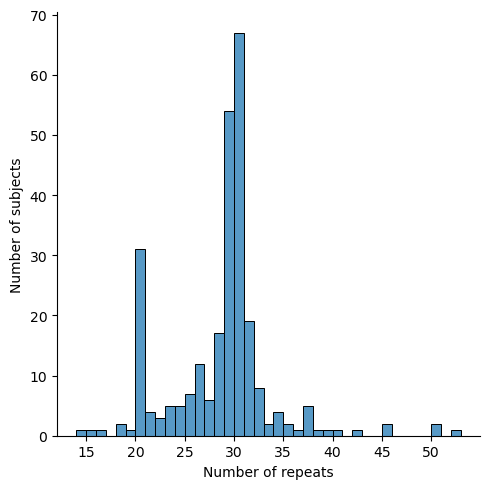

fragile_x//dist_repeats_FX_hps_PB.png


<Figure size 640x480 with 0 Axes>

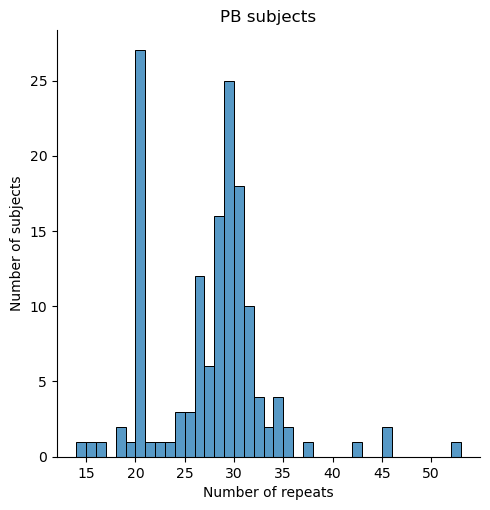

fragile_x//dist_repeats_FX_hps_ONT.png


<Figure size 640x480 with 0 Axes>

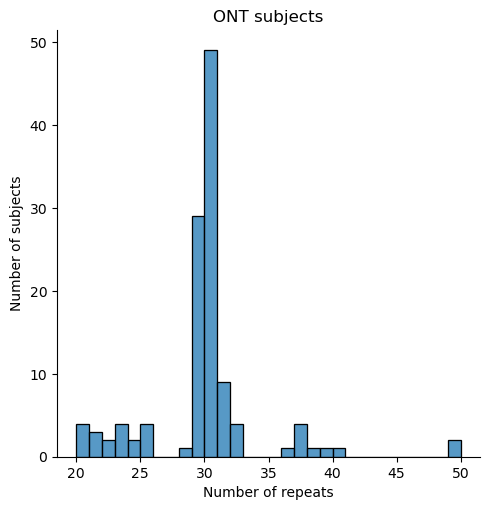

In [10]:
#df_flt = df.loc[df.HP_1!='.']

plt.figure()
sb.displot(data=df_fm_hp, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

### PB subjects
df_flt = df_fm_hp.loc[df_fm_hp.Platform!='PB']

plt.figure()
sb.displot(data=df_flt, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
plt.title('PB subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps_PB.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

### ONT subjects
df_flt = df_fm_hp.loc[df_fm_hp.Platform!='ONT']

plt.figure()
sb.displot(data=df_flt, x='repeat_hp', binwidth=1)
#rp_thr = 55
#y_max = 40
#plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
#plt.text(rp_thr, y_max, 'pre-mutation threshold')

#bp_thr = 78
##rp_thr = 70
##y_max = 10
#plt.plot([bp_thr, bp_thr], [0, y_max], '--k')
##plt.plot([rp_thr, rp_thr], [0, y_max], '--k')
##plt.text(rp_thr, y_max, '70 repeats')

plt.xlabel('Number of repeats')
plt.ylabel('Number of subjects')
plt.title('ONT subjects')
fig_name = f'{dir_fig}/dist_repeats_FX_hps_ONT.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

/scratch/smmortazavi/job_36192620/ipykernel_1988544/3071905325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.boxplot(data=df_flt, x='Affected', y='repeats_max', boxprops={'alpha': 0.5}, fliersize=0, palette=['red', 'blue'], width=0.4)


fragile_x//case_control_repeat_num.png


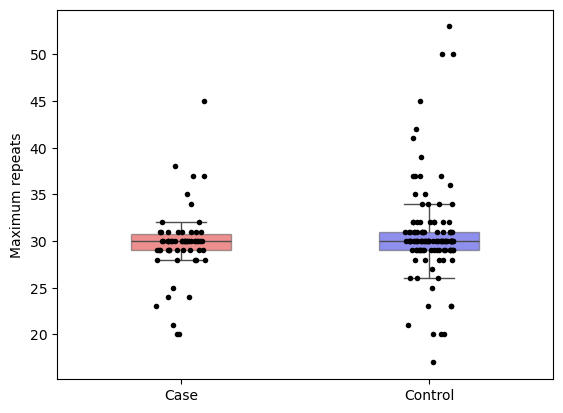

In [11]:
df_flt = df.loc[df.GB!="."].copy()
df_flt['Affected'] = ['Case' if x == 'Yes' else 'Control' for x in df_flt.Affected]
#display(df_flt)

plt.figure()
ax = sb.boxplot(data=df_flt, x='Affected', y='repeats_max', boxprops={'alpha': 0.5}, fliersize=0, palette=['red', 'blue'], width=0.4)
sb.stripplot(data=df_flt, x='Affected', y='repeats_max', ax=ax, legend=False, color='k', size=4)

plt.xlabel('')
plt.ylabel('Maximum repeats')
fig_name = f'{dir_fig}/case_control_repeat_num.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
df_flt_look = df.loc[df.GB!='.'].copy()
df_flt_look['GB_max'] = df_flt_look['GB_max'].astype(int)
df_flt_look = df_flt_look.loc[df_flt_look.GB_max>70]
df_flt_look_fam = df.loc[df.Fam_id.isin(df_flt_look.Fam_id)]
display(df_flt_look)
display(df_flt_look_fam)

,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
127,REACH000451,27|90,0.07|4.05,1,F0213,2,P,27,90,29,50,No,PB
129,REACH000453,33|91,0.45|4.11,1,F0213,2,C,33,91,31,50,No,PB
155,REACH000519,0|75,-1.64|3.10,1,F0230,2,C,0,75,20,45,No,ONT
181,REACH000560,77|77,3.23|3.23,0.25,F0241,1,C,77,77,45,45,Yes,ONT
184,REACH000563,18|101,-0.50|4.74,1,F0241,2,C,18,101,26,53,No,ONT


,Sample_id,GB,Z,Qual,Fam_id,sex,rel,GB_min,GB_max,repeats_min,repeats_max,Affected,Platform
126,REACH000450,.,.,.,F0213,2,C,.,.,.,.,No,PB
127,REACH000451,27|90,0.07|4.05,1,F0213,2,P,27,90,29,50,No,PB
128,REACH000452,.,.,.,F0213,1,P,.,.,.,.,No,PB
129,REACH000453,33|91,0.45|4.11,1,F0213,2,C,33,91,31,50,No,PB
154,REACH000518,20|28,-0.37|0.13,0.97,F0230,2,C,20,28,26,29,No,ONT
155,REACH000519,0|75,-1.64|3.10,1,F0230,2,C,0,75,20,45,No,ONT
156,REACH000523,20|28,-0.37|0.13,1,F0230,2,P,20,28,26,29,No,ONT
157,REACH000524,52|52,1.65|1.65,0.33,F0230,1,P,52,52,37,37,No,ONT
181,REACH000560,77|77,3.23|3.23,0.25,F0241,1,C,77,77,45,45,Yes,ONT
182,REACH000561,29|67,0.20|2.60,1,F0241,2,P,29,67,29,42,No,ONT


,Subject,haplotype,base pair deviation,repeats
0,REACH000563 (offspring),HP1,13,24
1,REACH000563 (offspring),HP1,24,28
2,REACH000563 (offspring),HP2,83,47
3,REACH000563 (offspring),HP2,100,53
4,REACH000563 (offspring),HP2,81,47
5,REACH000563 (offspring),HP2,95,51
6,REACH000563 (offspring),HP2,81,47
0,REACH000561 (mother),HP1,31,30
1,REACH000561 (mother),HP1,34,31
2,REACH000561 (mother),HP1,17,25


p_value: 0.007097771066893003
fragile_x//denovo_FX_REACH000563_repeats.png


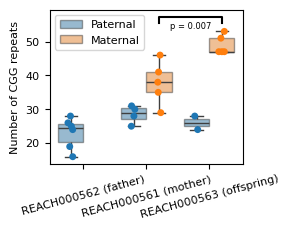

In [3]:
### F0241 family
# REACH000563: all reads are unphased
### NOTE: We identified a SNV comming from mother's haplotype at chrX:147,910,104 and the three reads in the child with that SNV. Two of those could be genotyped with snoopsv
###       and showed 81 and 95 base pair more than reference. So we can conclude that the longer repeat length is coming from the mother.
c_hp_all = [83,100,81,13,95,24,81]
c1_hp_2 = [83,100,81,95,81]
c1_hp_1 = [13,24]

# REACH000560: all reads are unphased, but he is male so it's on HP1
c2_hp_1 = [75]

# REACH000561 (mom): reads are phased
#m_hp_1 = [31,46,34,17,26]
#m_hp_2 = [79,55,28,65]

### correct a misplaced HP read:
m_hp_1 = [31,34,17,26]
m_hp_2 = [79,55,28,65,46]

# REACH000562 (dad): reads are all unphased but we have just one haplotype here
d_hp_all = [-10,12,20,-1,15,25]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000563 (offspring)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000560 (proband, M)' for x in range(len(c2_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]), 
                         'base pair deviation': c2_hp_1})
df_plt_m = pd.DataFrame({'Subject': ['REACH000561 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000562 (father)' for x in range(len(d_hp_all))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_all))]), 
                         'base pair deviation': d_hp_all})
#display(df_plt_c)
#display(df_plt_m)
#display(df_plt_d)

#order = ['REACH000560 (proband, M)', 'REACH000563 (sibling, F)', 'REACH000561 (mother)', 'REACH000562 (father)']
order = ['REACH000562 (father)', 'REACH000561 (mother)', 'REACH000563 (offspring)']

#df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt = pd.concat([df_plt_c1, df_plt_m, df_plt_d])

df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
display(df_plt)

FS = 8

plt.figure(figsize=(2.5, 2))
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5}, order=order)
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False, order=order)
plt.legend(fontsize=FS)
ax.legend(handles=ax.legend_.legend_handles, labels=['Paternal', "Maternal"], fontsize=FS)

# statistical annotation, Perform paired t-test
rep_mom_hp2 = df_plt.loc[(df_plt.Subject=='REACH000561 (mother)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
rep_sib_hp2 = df_plt.loc[(df_plt.Subject=='REACH000563 (offspring)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
#print(f'rep_mom_hp2: {rep_mom_hp2}')
#print(f'rep_sib_hp2: {rep_sib_hp2}')
t_stat, p_value = ttest_ind(rep_mom_hp2, rep_sib_hp2)
print(f'p_value: {p_value}')
dx = .2
x1, x2 = 1+dx, 2+dx   # columns (first column: 0, see plt.xticks())
y, h, col = (max(c1_hp_2) + 60)/3 + 2, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col, fontsize=FS-2)

plt.xticks(rotation=15, ha='center', fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlabel('')
plt.ylabel('Number of CGG repeats', fontsize=FS)
fig_name = f'{dir_fig}/denovo_FX_REACH000563_repeats.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

h1 array: [26.         45.66666667 29.66666667 26.        ]
h2 array: [53.66666667 42.33333333]


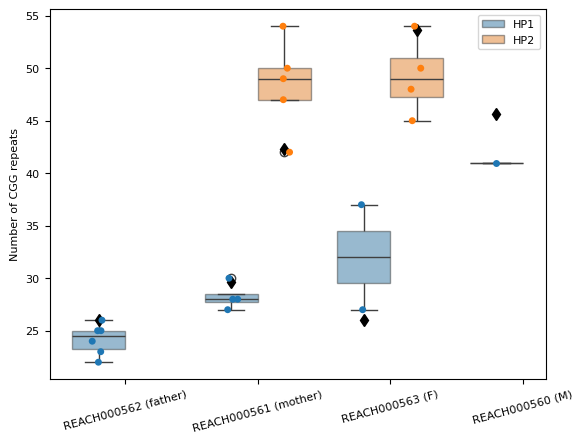

In [16]:
### F0241 family with NEW genotyping TRs
# REACH000563: all reads are unphased
### NOTE: We identified a SNV comming from mother's haplotype at chrX:147,910,104 and the three reads in the child with that SNV. Two of those could be genotyped with snoopsv
###       and showed 81 and 95 base pair more than reference. So we can conclude that the longer repeat length is coming from the mother.
#c_hp_all = [83,100,81,13,95,24,81]
#c1_hp_2 = [83,100,81,95,81] 
c1_hp_2 = [86,90,75,102]
#c1_hp_1 = [13,24]
c1_hp_1 = [21,53]
c1_ltr_hp_1 = 18
c1_ltr_hp_2 = 101
x_c1 = 2

# REACH000560: all reads are unphased, but he is male so it's on HP1
#c2_hp_1 = [75]
c2_hp_1 = [63]
c2_ltr_hp_1 = 77
x_c2 = 3

# REACH000561 (mom): reads are phased
#m_hp_1 = [31,46,34,17,26]
#m_hp_2 = [79,55,28,65]

### correct a misplaced HP read:
#m_hp_1 = [31,34,17,26]
m_hp_1 = [22,25,24,31]
#m_hp_2 = [79,55,28,65,46]
m_hp_2 = [92,88,102,67,83]
m_ltr_hp_1 = 29
m_ltr_hp_2 = 67
x_m = 1

# REACH000562 (dad): reads are all unphased but we have just one haplotype here
#d_hp_all = [-10,12,20,-1,15,25]
d_hp_all = [14,15,19,7,9,15]
d_ltr_hp_1 = 18
x_d = 0

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000563 (F)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000560 (M)' for x in range(len(c2_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]), 
                         'base pair deviation': c2_hp_1})
df_plt_m = pd.DataFrame({'Subject': ['REACH000561 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000562 (father)' for x in range(len(d_hp_all))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_all))]), 
                         'base pair deviation': d_hp_all})
#display(df_plt_c)
#display(df_plt_m)
#display(df_plt_d)

#order = ['REACH000560 (proband, M)', 'REACH000563 (sibling, F)', 'REACH000561 (mother)', 'REACH000562 (father)']
order = ['REACH000562 (father)', 'REACH000561 (mother)', 'REACH000563 (F)', 'REACH000560 (M)']

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
#df_plt = pd.concat([df_plt_c1, df_plt_m, df_plt_d])

df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
#display(df_plt)

FS = 8

plt.figure()
#(figsize=(2.5, 2))
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5}, order=order)
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False, order=order)
plt.legend(fontsize=FS)
ax.legend(handles=ax.legend_.legend_handles, labels=['HP1', "HP2"], fontsize=FS)

# statistical annotation, Perform paired t-test
#rep_mom_hp2 = df_plt.loc[(df_plt.Subject=='REACH000561 (mother)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
#rep_sib_hp2 = df_plt.loc[(df_plt.Subject=='REACH000563 (offspring)')&(df_plt.haplotype=='HP2'), 'repeats'].tolist()
#print(f'rep_mom_hp2: {rep_mom_hp2}')
#print(f'rep_sib_hp2: {rep_sib_hp2}')
#t_stat, p_value = ttest_ind(rep_mom_hp2, rep_sib_hp2)
#print(f'p_value: {p_value}')
#dx = .2
#x1, x2 = 1+dx, 2+dx   # columns (first column: 0, see plt.xticks())
#y, h, col = (max(c1_hp_2) + 60)/3 + 2, 2, 'k'

#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y-h, f"p = {p_value:.3f}", ha='center', va='bottom', color=col, fontsize=FS-2)

plt.xticks(rotation=15, ha='center', fontsize=FS)
plt.yticks(fontsize=FS)
plt.xlabel('')
plt.ylabel('Number of CGG repeats', fontsize=FS)

dx = 0.2
h1_arr = np.array([c1_ltr_hp_1, c2_ltr_hp_1, m_ltr_hp_1, d_ltr_hp_1])/3 + 20
h2_arr = np.array([c1_ltr_hp_2, m_ltr_hp_2])/3 + 20
print(f'h1 array: {h1_arr}')
print(f'h2 array: {h2_arr}')
plt.plot([x_c1-dx, x_c2-dx, x_m-dx, x_d-dx], h1_arr, 'dk')
plt.plot([x_c1+dx, x_m+dx], h2_arr, 'dk')
#fig_name = f'{dir_fig}/denovo_FX_REACH000563_repeats.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
plt.show()
plt.close()

h1 array: [29.33333333 45.         26.66666667 37.33333333]
h2 array: [26.66666667 20.         29.33333333]


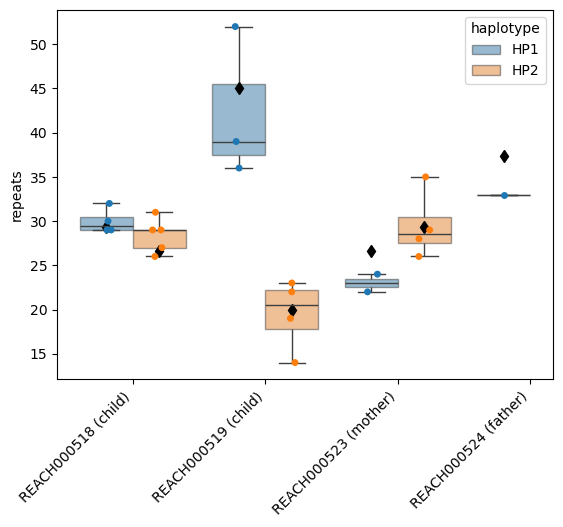

In [12]:
### F0230 family Chris family
# REACH000518:
#c1_hp_0 = [14,13]
#c1_hp_1 = [35,53,19,52]
c1_hp_1 = [27,30,27,36]
#c1_hp_2 = [19,29,30,36,21]
c1_hp_2 = [23,27,35,29,20]
c1_ltr_hp_1 = 28
c1_ltr_hp_2 = 20
x_c1 = 0

# REACH000519:
#c2_hp_1 = [18,58]
c2_hp_1 = [97,58,48]
#c2_hp_2 = [-6,2,14]
c2_hp_2 = [-16,10,-3,6]
c2_ltr_hp_1 = 75
c2_ltr_hp_2 = 0
x_c2 = 1

# REACH000523 (mom):
#m_hp_1 = [13,5]
m_hp_1 = [7,12]
#m_hp_2 = [44,19,12,26]
m_hp_2 = [45,24,20,28]
m_ltr_hp_1 = 20
m_ltr_hp_2 = 28
x_m = 2

# REACH000524 (dad):
#d_hp_1 = [45]
d_hp_1 = [39]
d_ltr_hp_1 = 52
x_d = 3

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000518 (child)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000519 (child)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000523 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000524 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
#display(df_plt_c1)
#display(df_plt_c2)
#display(df_plt_m)
#display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
#display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')

dx = 0.2
h1_arr = np.array([c1_ltr_hp_1, c2_ltr_hp_1, m_ltr_hp_1, d_ltr_hp_1])/3 + 20
h2_arr = np.array([c1_ltr_hp_2, c2_ltr_hp_2, m_ltr_hp_2])/3 + 20
print(f'h1 array: {h1_arr}')
print(f'h2 array: {h2_arr}')
plt.plot([x_c1-dx, x_c2-dx, x_m-dx, x_d-dx], h1_arr, 'dk')
plt.plot([x_c1+dx, x_c2+dx, x_m+dx], h2_arr, 'dk')
#fig_name = 'denovo_FX_REACH000519.png'
#fig_name = f'{dir_fig}/denovo_FX_REACH000519_repeats.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

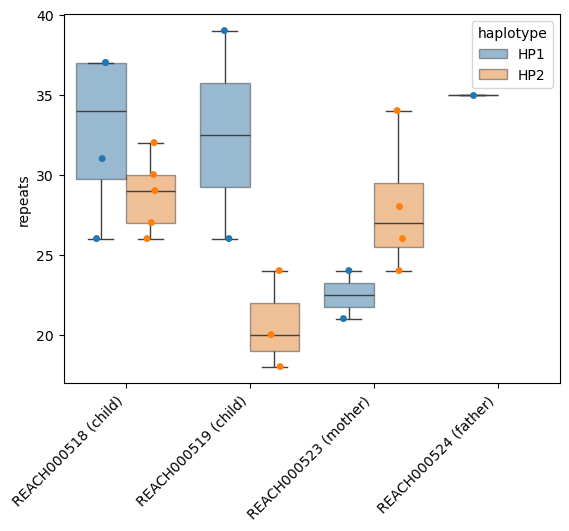

In [9]:
### F0230 family Chris family
# REACH000518:
#c1_hp_0 = [14,13]
c1_hp_1 = [35,53,19,52]
#c1_hp_1 = [27,30,27,36]
c1_hp_2 = [19,29,30,36,21]
#c1_hp_2 = [23,27,35,29,20]

# REACH000519:
c2_hp_1 = [18,58]
#c2_hp_1 = [97,58,48]
c2_hp_2 = [-6,2,14]
#c2_hp_2 = [-16,10,-3,6]

# REACH000523 (mom):
m_hp_1 = [13,5]
#m_hp_1 = [7,12]
m_hp_2 = [44,19,12,26]
#m_hp_2 = [45,24,20,28]

# REACH000524 (dad):
d_hp_1 = [45]
#d_hp_1 = [39]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000518 (child)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000519 (child)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000523 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000524 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
#display(df_plt_c1)
#display(df_plt_c2)
#display(df_plt_m)
#display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
#display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
#fig_name = 'denovo_FX_REACH000519.png'
#fig_name = f'{dir_fig}/denovo_FX_REACH000519_repeats.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

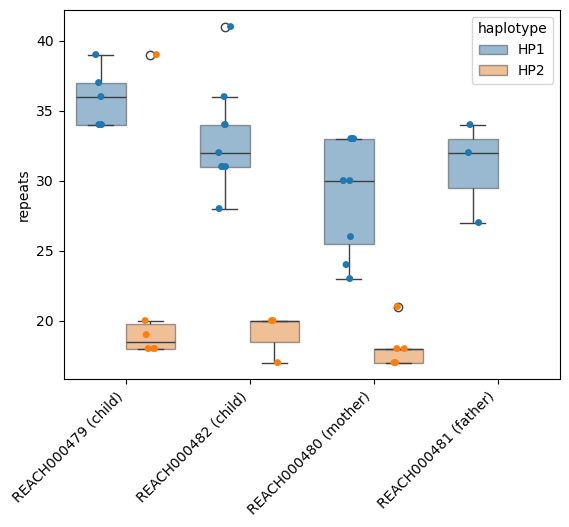

In [7]:
### F0221 family
# REACH000479:
c1_hp_1 = [48,42,43,51,57]
c1_hp_2 = [-5,-4,0,-4,57,-3]

# REACH000482:
c2_hp_1 = [42,65,34,36,33,44,26,50,34]
c2_hp_2 = [1,-8,0]

# REACH000480 (mom): this is all unphased, I separated it based on repeat separation between the bp deviations
# all reads: 41,30,31,-7,39,-5,39,11,4,-6,20,.,-7,14
m_hp_1 = [41,30,31,39,39,11,20,14]
m_hp_2 = [-7,-5,4,-6,-7]

# REACH000481 (dad):
d_hp_1 = [42,23,37]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000479 (child)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000482 (child)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000480 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000481 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
#display(df_plt_c1)
#display(df_plt_c2)
#display(df_plt_m)
#display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
#display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
#fig_name = 'denovo_FX_REACH000.png'
#fig_name = f'{dir_fig}/denovo_FX_REACH000_repeats.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

h1 array: [31. 29.]
h2 array: [50.33333333 50.        ]


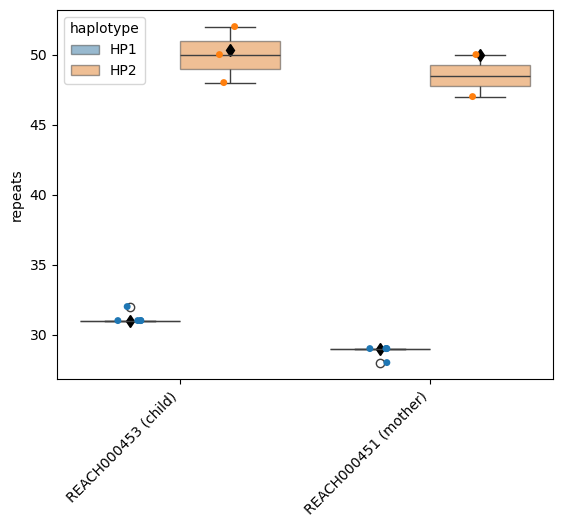

In [17]:
### F0213 family
# REACH000453:
c1_hp_1 = [33,33,33,36,33]
c1_hp_2 = [97,84,90]
c1_ltr_hp_1 = 33
c1_ltr_hp_2 = 91
x_c1 = 0

# REACH000:
#c2_hp_1 = []
#c2_hp_2 = []

# REACH000451 (mom):
m_hp_1 = [24,27,27,27,27]
m_hp_2 = [81,91]
m_ltr_hp_1 = 27
m_ltr_hp_2 = 90
x_m = 1

# REACH000452 (dad):
#d_hp_1 = []

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000453 (child)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
#df_plt_c2 = pd.DataFrame({'Subject': ['REACH000 (child)' for x in range(len(c2_hp_1+c2_hp_2))], 
#                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
#                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000451 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
#df_plt_d = pd.DataFrame({'Subject': ['REACH000452 (father)' for x in range(len(d_hp_1))], 
#                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
#                         'base pair deviation': d_hp_1})
#display(df_plt_c1)
#display(df_plt_c2)
#display(df_plt_m)
#display(df_plt_d)

#df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt = pd.concat([df_plt_c1, df_plt_m])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
#display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')

dx = 0.2
h1_arr = np.array([c1_ltr_hp_1, m_ltr_hp_1])/3 + 20
h2_arr = np.array([c1_ltr_hp_2, m_ltr_hp_2])/3 + 20
print(f'h1 array: {h1_arr}')
print(f'h2 array: {h2_arr}')
plt.plot([x_c1-dx, x_m-dx], h1_arr, 'dk')
plt.plot([x_c1+dx, x_m+dx], h2_arr, 'dk')
#fig_name = 'denovo_FX_REACH000.png'
#fig_name = f'{dir_fig}/denovo_FX_REACH000_repeats.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

,Subject,haplotype,base pair deviation
0,"REACH000510 (proband, F)",HP1,56
1,"REACH000510 (proband, F)",HP1,27
2,"REACH000510 (proband, F)",HP1,9
3,"REACH000510 (proband, F)",HP2,-14
4,"REACH000510 (proband, F)",HP2,46
5,"REACH000510 (proband, F)",HP2,-43
6,"REACH000510 (proband, F)",HP2,27


,Subject,haplotype,base pair deviation
0,"REACH000513 (sibling, F)",HP1,11
1,"REACH000513 (sibling, F)",HP2,31
2,"REACH000513 (sibling, F)",HP2,27
3,"REACH000513 (sibling, F)",HP2,20
4,"REACH000513 (sibling, F)",HP2,0


,Subject,haplotype,base pair deviation
0,REACH000511 (mother),HP1,9
1,REACH000511 (mother),HP2,32
2,REACH000511 (mother),HP2,27
3,REACH000511 (mother),HP2,14


,Subject,haplotype,base pair deviation
0,REACH000512 (father),HP1,28
1,REACH000512 (father),HP1,17
2,REACH000512 (father),HP1,30
3,REACH000512 (father),HP1,9
4,REACH000512 (father),HP1,40
5,REACH000512 (father),HP1,17


,Subject,haplotype,base pair deviation,repeats
0,"REACH000510 (proband, F)",HP1,56,38
1,"REACH000510 (proband, F)",HP1,27,29
2,"REACH000510 (proband, F)",HP1,9,23
3,"REACH000510 (proband, F)",HP2,-14,15
4,"REACH000510 (proband, F)",HP2,46,35
5,"REACH000510 (proband, F)",HP2,-43,5
6,"REACH000510 (proband, F)",HP2,27,29
0,"REACH000513 (sibling, F)",HP1,11,23
1,"REACH000513 (sibling, F)",HP2,31,30
2,"REACH000513 (sibling, F)",HP2,27,29


fragile_x//denovo_FX_REACH000510_repeats.png


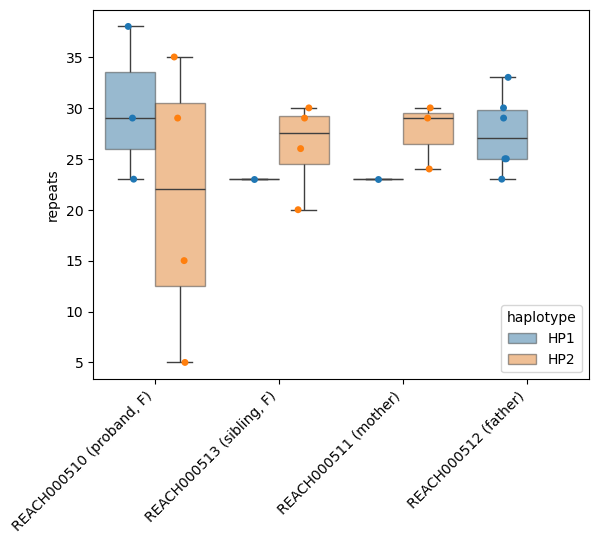

In [14]:
### F0228 family
# REACH000510 (pro):
c1_hp_1 = [56,27,9]
c1_hp_2 = [-14,46,-43,27]

# REACH000511 (mom):
m_hp_1 = [9]
m_hp_2 = [32,27,14]
#9:.:32,27,14

# REACH000512 (dad):
d_hp_1 = [28,17,30,9,40,17]

# REACH000513 (sib):
c2_hp_1 = [11]
c2_hp_2 = [31,27,20,0]

df_plt_c1 = pd.DataFrame({'Subject': ['REACH000510 (proband, F)' for x in range(len(c1_hp_1+c1_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c1_hp_1))]+['HP2' for x in range(len(c1_hp_2))]), 
                         'base pair deviation': c1_hp_1+c1_hp_2})
df_plt_c2 = pd.DataFrame({'Subject': ['REACH000513 (sibling, F)' for x in range(len(c2_hp_1+c2_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(c2_hp_1))]+['HP2' for x in range(len(c2_hp_2))]), 
                         'base pair deviation': c2_hp_1+c2_hp_2})
df_plt_m = pd.DataFrame({'Subject': ['REACH000511 (mother)' for x in range(len(m_hp_1+m_hp_2))], 
                         'haplotype': (['HP1' for x in range(len(m_hp_1))]+['HP2' for x in range(len(m_hp_2))]), 
                         'base pair deviation': m_hp_1+m_hp_2})
df_plt_d = pd.DataFrame({'Subject': ['REACH000512 (father)' for x in range(len(d_hp_1))], 
                         'haplotype': (['HP1' for x in range(len(d_hp_1))]), 
                         'base pair deviation': d_hp_1})
display(df_plt_c1)
display(df_plt_c2)
display(df_plt_m)
display(df_plt_d)

df_plt = pd.concat([df_plt_c1, df_plt_c2, df_plt_m, df_plt_d])
df_plt['repeats'] = ((df_plt['base pair deviation'] + 60)/3).astype(int)
display(df_plt)

plt.figure()
#ax = sb.boxplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', boxprops={'alpha': 0.5})
#sb.stripplot(data=df_plt, x='Subject', y='base pair deviation', hue='haplotype', dodge=True, ax=ax)
ax = sb.boxplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', boxprops={'alpha': 0.5})
sb.stripplot(data=df_plt, x='Subject', y='repeats', hue='haplotype', dodge=True, ax=ax, legend=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
fig_name = f'{dir_fig}/denovo_FX_REACH000510_repeats.png'
print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [18]:
### Do binomial test for num reads methylated and unmethylated
# samples: 
#REACH000519: large hp -> h1
#REACH000518: large hp -> h1
#REACH000561: large hp -> h2
#REACH000563: large hp -> h2
#REACH000451: large hp -> h2
#REACH000453: large hp -> h2

num_reads_methylated_large_hp = 3+3 + 5+3+2+3
num_reads_unmethylated_large_hp = 0+1 + 0+1+0+0

num_reads_methylated_small_hp = 1+0 + 0+0+1+3
num_reads_unmethylated_small_hp = 3+5 + 4+2+4+2

In [49]:
### Do the fisher's exact test to determine dependecy of methylation to repeat length
from scipy.stats import fisher_exact
from scipy.stats import binomtest
from scipy.stats import chi2_contingency

# 2x2 contingency table
#                      | large reps | small reps
# Methylated reads     |    a       |    b
# Unmethylated reads   |    c       |    d
table = [[num_reads_methylated_large_hp, num_reads_methylated_small_hp],
         [num_reads_unmethylated_large_hp, num_reads_unmethylated_small_hp]]

print('fishers test for large deviation subjects')
print(f'table: {table}')

# Perform Fisher's exact test
oddsratio, p_value = fisher_exact(table, alternative='two-sided')

print(f"Odds Ratio: {oddsratio}")
print(f"P-value: {p_value}")
print('+++++++++++++++++++++++++++++++++++')

print('Chi-squared test for large deviation subjects')
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for large deviation subjects: large reps')
# Perform two-tailed binomial test
k = num_reads_methylated_large_hp
n = num_reads_methylated_large_hp + num_reads_unmethylated_large_hp
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for large deviation subjects: small reps')
# Perform two-tailed binomial test
k = num_reads_methylated_small_hp
n = num_reads_methylated_small_hp + num_reads_unmethylated_small_hp
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

fishers test for large deviation subjects
table: [[19, 5], [2, 20]]
Odds Ratio: 38.0
P-value: 1.5100145263047636e-06
+++++++++++++++++++++++++++++++++++
Chi-squared test for large deviation subjects
Chi-squared statistic: 19.981291486291482
P-value: 7.820358404117223e-06
Degrees of freedom: 1
Expected frequencies:
[[10.95652174 13.04347826]
 [10.04347826 11.95652174]]
+++++++++++++++++++++++++++++++++++
binomial test for large deviation subjects: large reps
P-value: 0.00022125244140625
+++++++++++++++++++++++++++++++++++
binomial test for large deviation subjects: small reps
P-value: 0.004077315330505371
+++++++++++++++++++++++++++++++++++


In [55]:
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/fragile_x_all/methylation_table_h1_vs_h2.tsv'
df_hps = pd.read_table(file_in, sep='\t', header=0, index_col=0)
### figure out number of reads in the large and small CGG repeat haplotypes
df_hps[['num_methyl_reads_large_hp', 'num_methyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_methyl_reads_h1'], row['num_methyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_methyl_reads_h2'], row['num_methyl_reads_h1']), axis=1, result_type = 'expand')
df_hps[['num_unmethyl_reads_large_hp', 'num_unmethyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_unmethyl_reads_h1'], row['num_unmethyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_unmethyl_reads_h2'], row['num_unmethyl_reads_h1']), axis=1, result_type = 'expand')
### look at small deviation subjects
df_hps = df_hps.loc[df_hps.large_dev==False]
### restrict to high coverage haplotypes on both h1 and h2
df_hps = df_hps.loc[((df_hps.num_methyl_reads_h1 + df_hps.num_unmethyl_reads_h1)>=3) & ((df_hps.num_methyl_reads_h2 + df_hps.num_unmethyl_reads_h2)>=3)]
### omit subjects with the same repeat length
#df_hps = df_hps.loc[df_hps.mean_repeat_length_h1 != df_hps.mean_repeat_length_h2]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display(df_hps)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
print(df_hps.shape)

print('fishers exact test for medium deviation subjects:')
table = [[df_hps.num_methyl_reads_large_hp.sum(), df_hps.num_methyl_reads_small_hp.sum()],
         [df_hps.num_unmethyl_reads_large_hp.sum(), df_hps.num_unmethyl_reads_small_hp.sum()]]
print(f'table: {table}')

# Perform Fisher's exact test
oddsratio, p_value = fisher_exact(table, alternative='two-sided')

print(f"Odds Ratio: {oddsratio}")
print(f"P-value: {p_value}")
print('+++++++++++++++++++++++++++++++++++')

print('Chi-squared test for medium deviation subjects')
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for medium deviation subjects: large reps')
# Perform two-tailed binomial test
k = df_hps.num_methyl_reads_large_hp.sum()
n = df_hps.num_methyl_reads_large_hp.sum() + df_hps.num_unmethyl_reads_large_hp.sum()
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for medium deviation subjects: small reps')
# Perform two-tailed binomial test
k = df_hps.num_methyl_reads_small_hp.sum()
n = df_hps.num_methyl_reads_small_hp.sum() + df_hps.num_unmethyl_reads_small_hp.sum()
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

,bp_dev_h1,xci_read_mean_methyl_lik_h1,bp_dev_h2,xci_read_mean_methyl_lik_h2,bp_dev_h0,xci_read_mean_methyl_lik_h0,methyl_h1,methyl_h2,methyl_h0,repeat_length_h1,repeat_length_h2,repeat_length_h0,mean_repeat_length_h1,mean_repeat_length_h2,mean_repeat_length_h0,read_mean_methyl_lik_h1,read_mean_methyl_lik_h2,read_mean_methyl_lik_h0,num_methyl_reads_h1,num_unmethyl_reads_h1,frac_hap_methyl_h1,num_methyl_reads_h2,num_unmethyl_reads_h2,frac_hap_methyl_h2,num_methyl_reads_h0,num_unmethyl_reads_h0,frac_hap_methyl_h0,xci_num_methyl_reads_h1,xci_num_unmethyl_reads_h1,xci_frac_hap_methyl_h1,xci_num_methyl_reads_h2,xci_num_unmethyl_reads_h2,xci_frac_hap_methyl_h2,xci_num_methyl_reads_h0,xci_num_unmethyl_reads_h0,xci_frac_hap_methyl_h0,sample_id,rel,sex,coverage,Platform,Affected,in_trios,frac_hap_methyl_large_rep,frac_hap_methyl_small_rep,mean_large_rep,mean_small_rep,binomial_pval,binomial_phred,large_dev,num_methyl_reads_large_hp,num_methyl_reads_small_hp,num_unmethyl_reads_large_hp,num_unmethyl_reads_small_hp
REACH000220,"28,26,27,27","93,6,11,8,77,7,44,1,1,68,98","27,27,27,.","1,4,0,1,58,0,91,8,79,89,97,54,66,55,64,0,3,13,45",.,"32,7,6,5,41,7",0|0|0|2|1|11|7|1|2|1|2|11|2|12|2|24|11|6|1|1|0...,99|96|100|100|100|100|100|100|100|100|100|99|1...,.,"29,29,29,29","29,29,29,.",.,29.000000,29.000000,.,"4,62,1,27","95,2,1,1",.,1,3,0.250000,1,3,0.250000,.,.,.,4,7,0.363636,9,10,0.47368421052631576,0,6,0.000000,REACH000220,M,Female,3.82,PB,No,True,0.250000,0.250000,29.000000,29.000000,1.000000,-0.000000,False,1,1,3,3
REACH000234,"29,27,27","10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...","33,30,32,33,30","33,10,4,0,35,23,26,92,5,0,9,8,8,83,85,4,40,3,1...",.,"3,31,92",29|44|69|88|87|49|39|23|65|53|33|57|55|48|47|1...,92|44|99|100|100|100|99|99|100|100|100|100|98|...,.,"30,29,29","31,30,31,31,30",.,29.333333,30.600000,.,"47,85,82","79,75,81,89,13",.,2,1,0.666667,4,1,0.800000,.,.,.,10,13,0.434783,5,15,0.25,1,2,0.333333,REACH000234,M,Female,7.19,PB,No,True,0.800000,0.666667,30.600000,29.333333,0.726562,1.387270,False,4,2,1,1
REACH000365,"30,30,29,30,30,32,.","2,5,0,30","27,27,27,30","97,46,90,92,100,90,99",.,"50,13,2,34,96,33,96,7,61,28,80,58,0,9,92,49,0,...",98|82|100|100|99|100|100|100|100|100|100|100|1...,97|66|94|100|89|85|19|31|21|0|0|0|0|13|9|11|58...,.,"30,30,30,30,30,31,.","29,29,29,30",.,30.166667,29.250000,.,"99,96,4,0,83,2,0","62,87,99,0",.,3,4,0.428571,3,1,0.750000,.,.,.,0,4,0.000000,6,1,0.8571428571428571,22,42,0.343750,REACH000365,M,Female,6.72,PB,No,True,0.428571,0.750000,30.166667,29.250000,0.548828,2.605636,False,3,3,4,1
REACH000628,"30,31,30,32,.","16,69,58,0,100,92,2,96,98,94,99,0,18,0,98,97,8...","27,27,27,26,30","52,77,86,82,94,4,0,22",.,"62,30,91,0,1,81,81,10,0,73,100,0,2,87,98,5,98,...",0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,7|12|7|3|0|0|0|0|0|0|0|0|0|0|3|1|2|2|6|27|6|4|...,.,"30,30,30,31,.","29,29,29,29,30",.,30.250000,29.200000,.,"0,64,91,0,100","2,6,0,5,0",.,3,2,0.600000,0,5,0.000000,.,.,.,15,7,0.681818,5,3,0.625,12,10,0.545455,REACH000628,M,Female,6.20,PB,No,True,0.600000,0.000000,30.250000,29.200000,0.109375,9.610819,False,3,0,2,5
REACH000672,"30,29,30","86,1,11,71,69,8,10,1,0,0,83,100,100,0,1","30,30,30,30,30","63,95,91,3,1,94,88,100",.,"0,73,74,2,83,84,3,95,75,44",97|94|100|100|100|100|100|100|100|100|100|100|...,75|99|98|100|98|99|88|8|57|98|100|100|97|100|1...,.,"30,30,30","30,30,30,30,30",.,30.000000,30.000000,.,"88,64,92","86,0,99,93,87",.,3,0,1.000000,4,1,0.800000,.,.,.,6,9,0.400000,6,2,0.75,6,4,0.600000,REACH000672,M,Female,5.02,PB,No,True,1.000000,0.800000,30.000000,30.000000,1.000000,-0.000000,False,3,4,0,1
REACH000674,"30,30,30","89,0,10,6,14,92,0,2,11,54,94,1,87,0,3,2","31,33,30,34,30,30","0,45,61,57,3,32,88,17,95,99,0,98,54,95,0,84,100",.,"1,0,69,0,80,87,0,0,1,0,14,62,0,63,0,86,59,72,9...",0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|...,98|98|98|100|99|99|99|99|99|100|100|99|99|100|...,.,"30,30,30","30,31,30,31,30,30",.,30.000000,30.333333,.,"0,0,4","98,86,4,0,1,91",.,0,3,0.000000,3,3,0.5000

(11, 54)
fishers exact test for medium deviation subjects:
table: [[34, 18], [19, 30]]
Odds Ratio: 2.982456140350877
P-value: 0.009691882521146073
+++++++++++++++++++++++++++++++++++
Chi-squared test for medium deviation subjects
Chi-squared statistic: 6.135250555683087
P-value: 0.013251276823114578
Degrees of freedom: 1
Expected frequencies:
[[27.28712871 24.71287129]
 [25.71287129 23.28712871]]
+++++++++++++++++++++++++++++++++++
binomial test for medium deviation subjects: large reps
P-value: 0.053438810537711046
+++++++++++++++++++++++++++++++++++
binomial test for medium deviation subjects: small reps
P-value: 0.11140289106101878
+++++++++++++++++++++++++++++++++++


In [56]:
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/fragile_x_all/methylation_table_h1_vs_h2.tsv'
df_hps = pd.read_table(file_in, sep='\t', header=0, index_col=0)
### figure out number of reads in the large and small CGG repeat haplotypes
df_hps[['num_methyl_reads_large_hp', 'num_methyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_methyl_reads_h1'], row['num_methyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_methyl_reads_h2'], row['num_methyl_reads_h1']), axis=1, result_type = 'expand')
df_hps[['num_unmethyl_reads_large_hp', 'num_unmethyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_unmethyl_reads_h1'], row['num_unmethyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_unmethyl_reads_h2'], row['num_unmethyl_reads_h1']), axis=1, result_type = 'expand')
### look at small deviation subjects
df_hps = df_hps.loc[df_hps.large_dev==True]
### restrict to high coverage haplotypes on both h1 and h2
df_hps = df_hps.loc[((df_hps.num_methyl_reads_h1 + df_hps.num_unmethyl_reads_h1)>=3) & ((df_hps.num_methyl_reads_h2 + df_hps.num_unmethyl_reads_h2)>=3)]
### omit subjects with the same repeat length
df_hps = df_hps.loc[df_hps.mean_large_rep < 35]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display(df_hps)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
print(df_hps.shape)

print('fishers exact test for small deviation subjects:')
table = [[df_hps.num_methyl_reads_large_hp.sum(), df_hps.num_methyl_reads_small_hp.sum()],
         [df_hps.num_unmethyl_reads_large_hp.sum(), df_hps.num_unmethyl_reads_small_hp.sum()]]
print(f'table: {table}')

# Perform Fisher's exact test
oddsratio, p_value = fisher_exact(table, alternative='two-sided')

print(f"Odds Ratio: {oddsratio}")
print(f"P-value: {p_value}")
print('+++++++++++++++++++++++++++++++++++')

print('Chi-squared test for small deviation subjects')
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for small deviation subjects: large reps')
# Perform two-tailed binomial test
k = df_hps.num_methyl_reads_large_hp.sum()
n = df_hps.num_methyl_reads_large_hp.sum() + df_hps.num_unmethyl_reads_large_hp.sum()
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

print('binomial test for small deviation subjects: small reps')
# Perform two-tailed binomial test
k = df_hps.num_methyl_reads_small_hp.sum()
n = df_hps.num_methyl_reads_small_hp.sum() + df_hps.num_unmethyl_reads_small_hp.sum()
result = binomtest(k=k, n=n, p=0.5, alternative='two-sided')
print(f"P-value: {result.pvalue}")
print('+++++++++++++++++++++++++++++++++++')

,bp_dev_h1,xci_read_mean_methyl_lik_h1,bp_dev_h2,xci_read_mean_methyl_lik_h2,bp_dev_h0,xci_read_mean_methyl_lik_h0,methyl_h1,methyl_h2,methyl_h0,repeat_length_h1,repeat_length_h2,repeat_length_h0,mean_repeat_length_h1,mean_repeat_length_h2,mean_repeat_length_h0,read_mean_methyl_lik_h1,read_mean_methyl_lik_h2,read_mean_methyl_lik_h0,num_methyl_reads_h1,num_unmethyl_reads_h1,frac_hap_methyl_h1,num_methyl_reads_h2,num_unmethyl_reads_h2,frac_hap_methyl_h2,num_methyl_reads_h0,num_unmethyl_reads_h0,frac_hap_methyl_h0,xci_num_methyl_reads_h1,xci_num_unmethyl_reads_h1,xci_frac_hap_methyl_h1,xci_num_methyl_reads_h2,xci_num_unmethyl_reads_h2,xci_frac_hap_methyl_h2,xci_num_methyl_reads_h0,xci_num_unmethyl_reads_h0,xci_frac_hap_methyl_h0,sample_id,rel,sex,coverage,Platform,Affected,in_trios,frac_hap_methyl_large_rep,frac_hap_methyl_small_rep,mean_large_rep,mean_small_rep,binomial_pval,binomial_phred,large_dev,num_methyl_reads_large_hp,num_methyl_reads_small_hp,num_unmethyl_reads_large_hp,num_unmethyl_reads_small_hp
REACH000436_PB,"15,12,9,8","59,0,81,0,3,11,36,19,4,31,0,62,0,19,64,0,3,100","30,27,30,30,30,30","0,44,43,0,48,50,67,80,0,90,0,0,0,71",.,"0,0,99,33,1,84,91,0,29,0,0,0,76,17",4|6|5|6|0|0|0|0|1|2|1|4|7|9|2|2|2|6|3|0|3|28|5...,0|0|0|0|0|0|0|0|0|0|1|1|0|0|0|0|0|0|0|0|0|0|0|...,.,"25,24,23,23","30,29,30,30,30,30",.,23.750000,29.833333,.,"24,89,77,2","0,88,3,0,98,0",.,2,2,0.500000,2,4,0.333333,.,.,.,5,13,0.277778,5,9,0.35714285714285715,4,10,0.285714,REACH000436_PB,M,Female,7.05,PB,No,True,0.333333,0.500000,29.833333,23.750000,0.753906,1.226827,True,2,2,4,2
REACH000404,"38,28,14,24","70,12,17,12,3,3,3,45,72,7,73,6,1,6,4,12,32,58,...","30,-2,-6,7,2,-22,-15","75,86,66,7,9,81,64,47,81,83,8,64,16,1,68,3,48,...","10,-21,-5,-20","82,62,2,59,64,1,6,10,25,7,85,43,35,3,58,79,71,...",15|89|65|0|45|100|84|1|0|0|0|26|0|0|0|44|1|29|...,95|69|100|95|89|100|99|99|99|100|100|100|98|10...,0|0|0|0|0|1|2|7|14|0|0|0|0|0|0|89|0|0|22|7|1|0...,"33,29,25,28","30,19,18,22,21,13,15","23,13,18,13",28.750000,19.714286,16.75,"21,2,60,2","87,68,89,73,52,7,7","5,56,19,78",1,3,0.250000,5,2,0.714286,2,2,0.5,14,26,0.350000,11,10,0.5238095238095238,10,11,0.476190,REACH000404,C,Female,10.31,ONT,Yes,True,0.250000,0.714286,28.750000,19.714286,0.226562,6.448120,True,1,5,3,2
REACH000417,"23,-23,29","79,62,76,3,34,59,5,4,1,74,45,7,8,2,1,35,66,6","48,3,23,26,30","86,45,78,55,56,63,5,12,38,10,62,97","30,.","73,4,23,47,58,84,43,80,7,64,3,5,94,70,4,79,71,...",100|0|100|3|29|99|64|0|100|2|0|7|98|100|99|89|...,99|58|83|100|91|100|100|100|100|100|29|37|65|5...,0|90|100|52|80|100|100|99|100|100|99|100|100|1...,"28,12,30","36,21,28,29,30","30,.",23.333333,28.800000,30.0,"63,44,79","75,67,85,6,77","90,81",2,1,0.666667,4,1,0.800000,2,0,1.0,6,12,0.333333,7,5,0.5833333333333334,18,19,0.486486,REACH000417,C,Female,11.36,ONT,No,True,0.800000,0.666667,28.800000,23.333333,0.726562,1.387270,True,4,2,1,1
REACH000435,"17,45,26,35,19,22,18","59,50,15,66,55,66,13,51","5,11,-5","63,2,78,3,4,16,1,2,52,43,3,31","26,34,-9,16","80,62,6,51,7,45,28,18,0,24,1,80,2,70,23,58,22,...",64|99|1|93|96|90|82|48|16|38|100|99|97|0|52|60...,0|0|1|13|0|0|0|0|0|0|0|0|0|0|6|23|7|0|0|70|41|...,72|100|100|98|100|97|93|100|100|100|100|100|79...,"26,35,29,32,26,27,26","22,24,18","29,31,17,25",28.714286,21.333333,25.5,"60,81,4,12,4,90,91","5,12,4","80,39,5,77",4,3,0.571429,0,3,0.000000,2,2,0.5,6,2,0.750000,3,9,0.25,10,16,0.384615,REACH000435,C,Female,8.97,ONT,Yes,True,0.571429,0.000000,28.714286,21.333333,0.343750,4.637573,True,4,0,3,3
REACH000482,"42,65,34,36,33,44,26,50,34","25,70,63,3,8,63,71,22,9,6,14,74,86,18,7,49,74,...","1,-8,0","75,79,71,8,55,84,76,63,55,79,16,25,9,11,87,60,...",41,"51,84,61,63,1,88,5,45,74,62,70,16,71,70,65,66,...",1|0|1|0|1|0|18|0|0|0|2|0|0|0|0|0|0|51|6|7|4|23...,0|12|2|3|0|20|0|2|67|74|0|0|0|0|0|0|0|0|0|5|2|...,0|8|68|0|84|0|1|0|7|1|0|0|0|0|0|0|0|0|1|0|0|0|...,"34,42,31,32,31,35,29,37,31","20,17,20",34,33.555556,19.000000,34.0,"12,68,8,78,4,31,12,6,5","7,6,66",6,2,7,0.222222,1,2,0.333333,0,1,0.0

(6, 54)
fishers exact test for small deviation subjects:
table: [[15, 12], [20, 12]]
Odds Ratio: 0.75
P-value: 0.6067673461975193
+++++++++++++++++++++++++++++++++++
Chi-squared test for small deviation subjects
Chi-squared statistic: 0.07562382881393323
P-value: 0.7833178743072791
Degrees of freedom: 1
Expected frequencies:
[[16.01694915 10.98305085]
 [18.98305085 13.01694915]]
+++++++++++++++++++++++++++++++++++
binomial test for small deviation subjects: large reps
P-value: 0.4995598332025112
+++++++++++++++++++++++++++++++++++
binomial test for small deviation subjects: small reps
P-value: 1.0
+++++++++++++++++++++++++++++++++++


,bp_dev_h1,xci_read_mean_methyl_lik_h1,bp_dev_h2,xci_read_mean_methyl_lik_h2,bp_dev_h0,xci_read_mean_methyl_lik_h0,methyl_h1,methyl_h2,methyl_h0,repeat_length_h1,repeat_length_h2,repeat_length_h0,mean_repeat_length_h1,mean_repeat_length_h2,mean_repeat_length_h0,read_mean_methyl_lik_h1,read_mean_methyl_lik_h2,read_mean_methyl_lik_h0,num_methyl_reads_h1,num_unmethyl_reads_h1,frac_hap_methyl_h1,num_methyl_reads_h2,num_unmethyl_reads_h2,frac_hap_methyl_h2,num_methyl_reads_h0,num_unmethyl_reads_h0,frac_hap_methyl_h0,xci_num_methyl_reads_h1,xci_num_unmethyl_reads_h1,xci_frac_hap_methyl_h1,xci_num_methyl_reads_h2,xci_num_unmethyl_reads_h2,xci_frac_hap_methyl_h2,xci_num_methyl_reads_h0,xci_num_unmethyl_reads_h0,xci_frac_hap_methyl_h0,sample_id,rel,sex,coverage,Platform,Affected,in_trios,frac_hap_methyl_large_rep,frac_hap_methyl_small_rep,mean_large_rep,mean_small_rep,binomial_pval,binomial_phred,large_dev,num_methyl_reads_large_hp,num_methyl_reads_small_hp,num_unmethyl_reads_large_hp,num_unmethyl_reads_small_hp,skewness
REACH000089,"31,30","54,51,2,91,51","30,30,32","82,52,94",.,"47,5,6,28,11,1,0,22,4,96,7,13,13,25,78,83,81,9...",5|9|3|4|24|19|29|89|99|100|100|99|97|99|93|76|...,82|69|81|83|45|73|55|13|24|33|82|67|43|60|86|9...,.,"30,30","30,30,31",.,30.000000,30.333333,.,"62,2","85,73,9",.,1,1,0.500000,2,1,0.666667,.,.,.,4,1,0.800000,3,0,1.0,6,14,0.300000,REACH000089,C,Female,3.27,PB,Yes,True,0.666667,0.500000,30.333333,30.000000,1.000000,-0.000000,False,2,1,1,1,0.221849
REACH000220,"28,26,27,27","93,6,11,8,77,7,44,1,1,68,98","27,27,27,.","1,4,0,1,58,0,91,8,79,89,97,54,66,55,64,0,3,13,45",.,"32,7,6,5,41,7",0|0|0|2|1|11|7|1|2|1|2|11|2|12|2|24|11|6|1|1|0...,99|96|100|100|100|100|100|100|100|100|100|99|1...,.,"29,29,29,29","29,29,29,.",.,29.000000,29.000000,.,"4,62,1,27","95,2,1,1",.,1,3,0.250000,1,3,0.250000,.,.,.,4,7,0.363636,9,10,0.47368421052631576,0,6,0.000000,REACH000220,M,Female,3.82,PB,No,True,0.250000,0.250000,29.000000,29.000000,1.000000,-0.000000,False,1,1,3,3,0.000000
REACH000230,"32,28","0,5,98","-1,0,7","75,1,2,27",.,"62,14,65,80",0|0|0|0|0|2|13|4|22|16|11|18|6|0|1|1|2|2|0|1|0...,61|79|92|98|98|99|100|99|97|100|99|99|98|98|98...,.,"31,29","20,20,22",.,30.000000,20.666667,.,"9,13","92,61,1",.,0,2,0.000000,2,1,0.666667,.,.,.,1,2,0.333333,1,3,0.25,3,1,0.750000,REACH000230,M,Female,0.92,PB,No,True,0.000000,0.666667,30.000000,20.666667,0.375000,4.259687,True,0,2,2,1,-0.920819
REACH000234,"29,27,27","10,8,80,74,11,8,80,28,55,63,0,46,21,43,81,69,9...","33,30,32,33,30","33,10,4,0,35,23,26,92,5,0,9,8,8,83,85,4,40,3,1...",.,"3,31,92",29|44|69|88|87|49|39|23|65|53|33|57|55|48|47|1...,92|44|99|100|100|100|99|99|100|100|100|100|98|...,.,"30,29,29","31,30,31,31,30",.,29.333333,30.600000,.,"47,85,82","79,75,81,89,13",.,2,1,0.666667,4,1,0.800000,.,.,.,10,13,0.434783,5,15,0.25,1,2,0.333333,REACH000234,M,Female,7.19,PB,No,True,0.800000,0.666667,30.600000,29.333333,0.726562,1.387270,False,4,2,1,1,0.255273
REACH000314,"27,29,28,30","85,96,57,8,78","30,37","100,7,15,79,17,34,9,1,21,4,84,96,4,68,2,3,46,9...",38,62,0|0|1|27|11|19|4|10|43|8|1|0|0|0|0|0|0|1|1|1|1...,5|1|10|14|5|7|5|9|59|29|4|5|20|23|10|6|2|1|0|0...,44|62|73|59|25|36|58|81|98|98|97|92|93|98|82|7...,"29,30,29,30","30,32",33,29.500000,31.000000,33.0,"4,79,85,7","16,63",79,2,2,0.500000,1,1,0.500000,1,0,1.0,4,1,0.800000,9,13,0.4090909090909091,1,0,1.000000,REACH000314,M,Female,4.03,PB,No,True,0.500000,0.500000,31.000000,29.500000,1.000000,-0.000000,False,1,2,1,2,0.000000
REACH000365,"30,30,29,30,30,32,.","2,5,0,30","27,27,27,30","97,46,90,92,100,90,99",.,"50,13,2,34,96,33,96,7,61,28,80,58,0,9,92,49,0,...",98|82|100|100|99|100|100|100|100|100|100|100|1...,97|66|94|100|89|85|19|31|21|0|0|0|0|13|9|11|58...,.,"30,30,30,30,30,31,.","29,29,29,30",.,30.166667,29.250000,.,"99,96,4,0,83,2,0","62,87,99,0",.,3,4,0.428571,3,1,0.750000,.,.,.,0,4,0.000000,6,1,0.8571428571428571,22,42,0.343750,REACH000365,M,Female,6.72,PB,No,True,0.428571,0.750000,30.166667,29.250000,0.548828,2.605636,False,3,3,4,1,-

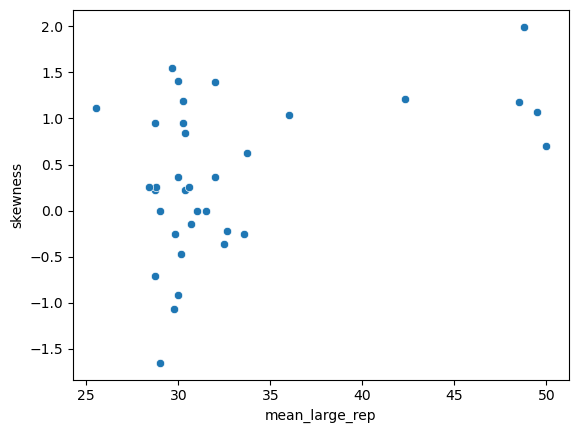

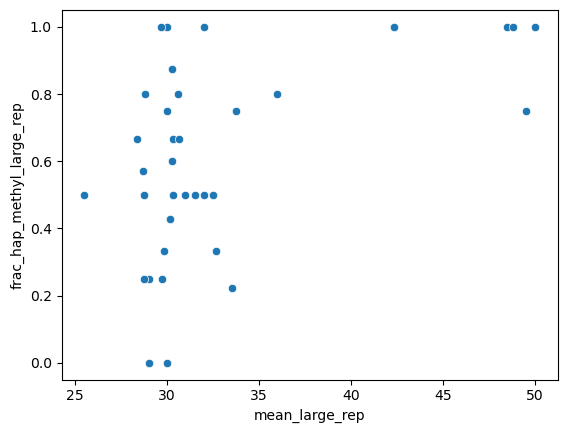

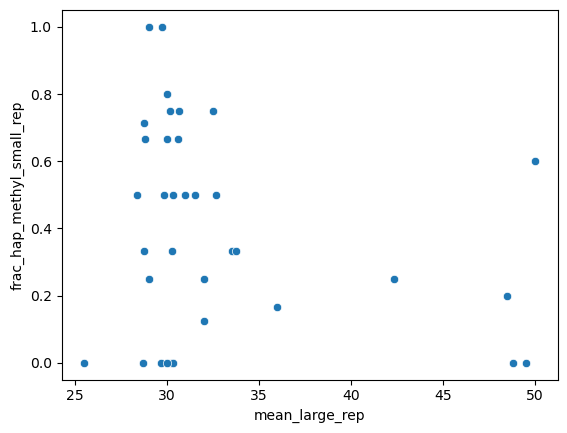

In [72]:
file_in = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/variant_prior/SV_process/fragile_x_all/methylation_table_h1_vs_h2.tsv'
df_hps = pd.read_table(file_in, sep='\t', header=0, index_col=0)
### figure out number of reads in the large and small CGG repeat haplotypes
df_hps[['num_methyl_reads_large_hp', 'num_methyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_methyl_reads_h1'], row['num_methyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_methyl_reads_h2'], row['num_methyl_reads_h1']), axis=1, result_type = 'expand')
df_hps[['num_unmethyl_reads_large_hp', 'num_unmethyl_reads_small_hp']] = df_hps.apply(lambda row: (row['num_unmethyl_reads_h1'], row['num_unmethyl_reads_h2']) if 
                                                                                                (row['mean_repeat_length_h1'] >= row['mean_repeat_length_h2']) 
                                                                                                else (row['num_unmethyl_reads_h2'], row['num_unmethyl_reads_h1']), axis=1, result_type = 'expand')

### skewness is defined as the odds ratio of methylated/unmethylated in large/small reps. basically the OR of the contingency table
eps = .5
df_hps['skewness'] = ((df_hps.num_methyl_reads_large_hp+eps) / (df_hps.num_unmethyl_reads_large_hp+eps)) / ((df_hps.num_methyl_reads_small_hp+eps) / (df_hps.num_unmethyl_reads_small_hp+eps))
df_hps['skewness'] = df_hps['skewness'].apply(np.log10)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display(df_hps)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

plt.figure()
sb.scatterplot(data=df_hps, x='mean_large_rep', y='skewness')#, hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
#plt.plot([0,50], [0,50], '--')
#plt.ylim((0,3))
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_hps, x='mean_large_rep', y='frac_hap_methyl_large_rep')#, hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_hps, x='mean_large_rep', y='frac_hap_methyl_small_rep')#, hue='subject', size='num_reads', sizes=(5,20)) # sizes gets a min max tuple interpreted by "size"
plt.show()
plt.close()

In [15]:
pd.set_option('display.max_rows', None)
#df_flt_look = df.loc[df.repeats_max>55]
#df_flt_look_fam = df.loc[df.Fam_id.isin(df_flt_look.Fam_id)]
#display(df_flt_look)
#display(df_flt_look_fam)

In [20]:
print(df_flt.shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats>55)].shape)
display(df_flt.loc[(df_flt.sex==2)&(df_flt.max_repeats>55)].shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats==55)].shape)
display(df_flt.loc[(df_flt.sex==2)&(df_flt.max_repeats==55)].shape)
display(df_flt.loc[(df_flt.sex==1)&(df_flt.max_repeats>=55)])

(47, 11)


(16, 11)

(19, 11)

(7, 11)

(5, 11)

,Sample_id,HP_1,HP_2,Qual,Fam_id,sex,rel,MAX_HP,max_repeats,Affected,Platform
6,REACH000058,51|51,1.58|1.58,0.97,F0058,1,C,51,61,Yes,PB
9,REACH000441,51|51,1.58|1.58,0.33,F0058,1,C,51,61,No,PB
15,REACH000088,31|34,0.32|0.51,0.99,F0078,1,P,34,55,No,PB
19,REACH000094,34|34,0.51|0.51,0.33,F0081,1,P,34,55,No,PB
27,REACH000154,26|34,0.01|0.51,1,F0125,1,C,34,55,Yes,ONT
42,REACH000214,30|37,0.26|0.70,1,F0152,1,C,37,56,Yes,PB
48,REACH000221,34|37,0.51|0.70,0.81,F0154,1,P,37,56,No,PB
75,REACH000295,36|36,0.64|0.64,0.67,F0176,1,P,36,56,No,PB
77,REACH000315,30|35,0.26|0.57,1,F0181,1,P,35,55,No,PB
103,REACH000416,25|43,-0.06|1.08,1,F0206,1,P,43,58,No,ONT


dist_density_bp_div_FX.png


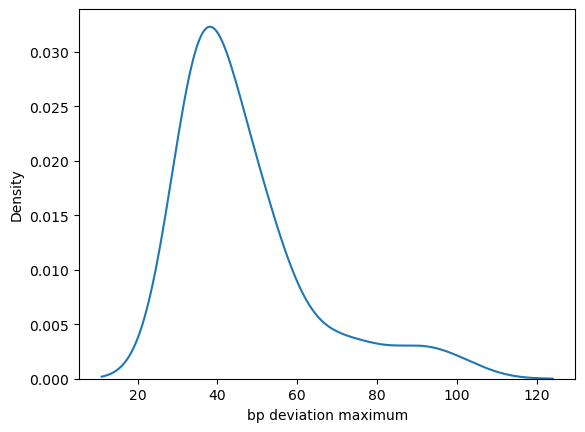

In [7]:
plt.figure()
sb.kdeplot(data=df_flt, x='MAX_HP', common_norm=False)
#sb.displot(data=df_flt, x='MAX_HP', binwidth=3)
#plt.xticks(rotation=45, ha='right')
plt.xlabel('bp deviation maximum')
#plt.title(title)
#plt.ylabel(f'Fraction of LR ({col_lr}) in IL')
fig_name = 'dist_density_bp_div_FX.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()